In [2]:
import numpy as np
from PIL import Image, ImageDraw, ImageChops

%run utils.ipynb

In [16]:
class KernelGenotype:
    OP_CODE_LINE = 'LINE'
    OP_CODE_CIRCLE = 'CIRCLE'
    OP_CODE_RECT = 'RECT'
    OP_CODES = [OP_CODE_LINE, OP_CODE_CIRCLE, OP_CODE_RECT]

    COMPOSE_TYPE_OR = 'OR'
    COMPOSE_TYPE_XOR = 'XOR'
    COMPOSE_TYPE_AND = 'AND'
    
    COMPOSE_TYPES = [COMPOSE_TYPE_OR, COMPOSE_TYPE_XOR, COMPOSE_TYPE_AND]
    
    def __init__(self):
        super()
        self.ops = []

    def __eq__(self, other): 
        if not isinstance(other, KernelGenotype):
            raise NotImplemented

        return self.ops == other.ops

    @classmethod
    def random(cls, depth=10):
        g = cls()
        
        for i in range(depth):
            op_code_index = np.random.randint(len(KernelGenotype.OP_CODES))
            op_code = KernelGenotype.OP_CODES[op_code_index] 
            compose_type_index = np.random.randint(len(KernelGenotype.COMPOSE_TYPES))
            compose_type = KernelGenotype.COMPOSE_TYPES[compose_type_index] if i > 0 else KernelGenotype.COMPOSE_TYPE_OR
            op = KernelGenotype.generate_op(op_code, compose_type)
            g.ops.append(op)

        return g

    @classmethod
    def from_ops(cls, ops):
        g = cls()
        g.ops = ops
        return g

    @staticmethod
    def generate_op(op_code, compose_type):
        params = KernelGenotype.generate_params(op_code)
        return dict(
            op=op_code,
            compose=compose_type,
            **params
        )

    @staticmethod 
    def generate_params(op_code):
        generators = {
            KernelGenotype.OP_CODE_LINE: KernelGenotype.generate_params_line,
            KernelGenotype.OP_CODE_CIRCLE: KernelGenotype.generate_params_circle,
            KernelGenotype.OP_CODE_RECT: KernelGenotype.generate_params_rect
        }

        assert op_code in generators.keys()
        return generators[op_code]()

    @staticmethod
    def generate_params_line():
        return dict(
            coords=np.random.randn(4),
            width=1 + np.random.randint(3)
        )

    @staticmethod
    def generate_params_circle():
        return dict(
            center=np.random.randn(2),
            radius=abs(np.random.randn()),
            width=1 + np.random.randint(3)
        )

    @staticmethod
    def generate_params_rect():
        return dict(
            coords=np.random.randn(4),
            width=1 + np.random.randint(3)
        )

    @staticmethod
    def build_op(op_code, compose_type, **kwargs):
        return dict(
            op=op_code,
            compose=compose_type,
            **kwargs
        )

    # produces kernel mask/matrix based on ops
    def build_phenotype(self, kernel_size):
        assert kernel_size > 0
        m = Image.new('1', (kernel_size, kernel_size), 0)

        if not self.ops:
            return m
            
        layer = Image.new('1', (kernel_size, kernel_size), 0)
        draw = ImageDraw.Draw(layer)
        drawers = {
            KernelGenotype.OP_CODE_LINE: KernelGenotype.draw_line,
            KernelGenotype.OP_CODE_CIRCLE: KernelGenotype.draw_circle,
            KernelGenotype.OP_CODE_RECT: KernelGenotype.draw_rect
        }
        composers = {
            KernelGenotype.COMPOSE_TYPE_OR: ImageChops.logical_or,
            KernelGenotype.COMPOSE_TYPE_XOR: ImageChops.logical_xor,
            KernelGenotype.COMPOSE_TYPE_AND: ImageChops.logical_and,
        }
        
        for op in self.ops:
            draw.rectangle([0, 0, kernel_size -1, kernel_size - 1], 0)
            op_code = op['op']

            if not op_code in drawers:
                print(f'Unknown OP_CODE={op_code}!')
                continue

            compose_type = op['compose']

            if not compose_type in composers:
                print(f'Unknown COMPOSE_TYPE={compose_type}!')
                continue

            drawer = drawers[op_code]
            drawer(kernel_size, draw, op)
            composer = composers[compose_type]
            m = composer(m, layer)

        return m

    @staticmethod
    def draw_line(sz, draw, params):
        xy = KernelGenotype.translate_coords(params['coords'], sz)
        #print(f'kms@ xy={xy}')
        width = params.get('width', 1)
        draw.line(xy, width=width, fill='white')

    @staticmethod
    def draw_rect(sz, draw, params):
        xy = KernelGenotype.translate_coords(params['coords'], sz)
        def enforce_asc(i, j):
            if xy[i] > xy[j]:
                t = xy[j]
                xy[j] = xy[i]
                xy[i] = t
        enforce_asc(0, 2)
        enforce_asc(1, 3)
        #print(f'kms@ xy={xy}')
        width = params.get('width', 1)
        draw.rectangle(xy, width=width, outline='white')

    @staticmethod
    def draw_circle(sz, draw, params):
        center = KernelGenotype.translate_coords(params['center'], sz)
        radius = int(params['radius'] * (sz - 1) / 2)
        #print(f'kms@ center={center} radius={radius}')
        width = params.get('width', 1)
        draw.circle(center, radius, width=width, outline='white')

    @staticmethod
    def translate_coords(coords, sz):
        assert sz > 1
        half_sz = (sz - 1) / 2
        xy = []
        
        for i, v in enumerate(coords):
            # y coord (odd) => revert, x coord (even) => no revert
            v = v * (half_sz if i % 2 == 0 else -half_sz)
            v += half_sz
            xy.append(int(v))

        return xy


In [11]:
# horz line
ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_LINE, KernelGenotype.COMPOSE_TYPE_OR, coords=[-1, 0, 1, 0], width=1) 
]
g = KernelGenotype.from_ops(ops)
img = g.build_phenotype(7)
fact = pil_image_to_2d_bytes(img)

expected = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
], dtype=np.uint8)
assert np.array_equal(expected, fact)

# vert line
ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_LINE, KernelGenotype.COMPOSE_TYPE_OR, coords=[0, 1, 0, -1], width=1) 
]
g = KernelGenotype.from_ops(ops)
img = g.build_phenotype(7)
fact = pil_image_to_2d_bytes(img)
assert np.array_equal(expected.T, fact)

# cross with hole inside
ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_LINE, KernelGenotype.COMPOSE_TYPE_OR, coords=[0, 1, 0, -1], width=1), 
    KernelGenotype.build_op(KernelGenotype.OP_CODE_LINE, KernelGenotype.COMPOSE_TYPE_XOR, coords=[-1, 0, 1, 0], width=1) 
]
g = KernelGenotype.from_ops(ops)
img = g.build_phenotype(7)
fact = pil_image_to_2d_bytes(img)
assert np.array_equal(np.bitwise_xor(expected, expected.T), fact)

# circle
ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_CIRCLE, KernelGenotype.COMPOSE_TYPE_OR, center=[0, 0], radius=1, width=1), 
]
expected = np.array([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0],
], dtype=np.uint8)
g = KernelGenotype.from_ops(ops)
img = g.build_phenotype(3)
fact = pil_image_to_2d_bytes(img)
assert np.array_equal(expected, fact)

# rect
ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_RECT, KernelGenotype.COMPOSE_TYPE_OR, coords=[-1, -1, 1, 1], width=1), 
]
expected = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1],
], dtype=np.uint8)
g = KernelGenotype.from_ops(ops)
img = g.build_phenotype(3)
fact = pil_image_to_2d_bytes(img)
assert np.array_equal(expected, fact)

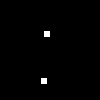

In [5]:
g = KernelGenotype.random(10)
#print(g.ops)
g.build_phenotype(32).resize((100, 100))

In [6]:
g.ops[0]

{'op': 'LINE',
 'compose': 'OR',
 'coords': array([-0.50667723, -0.12476873, -1.09777787,  1.20526051]),
 'width': 2}

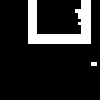

In [7]:
ops2 = [
    g.ops[0],
    g.ops[1],
    g.ops[2],
    g.ops[3],
    g.ops[4],
    g.ops[5],
]
KernelGenotype.from_ops(ops2).build_phenotype(32).resize((100, 100))

In [27]:
import copy
g_empty1 = KernelGenotype()
g_empty2 = KernelGenotype()
assert g_empty1 == g_empty2

ops = [
    KernelGenotype.build_op(KernelGenotype.OP_CODE_RECT, KernelGenotype.COMPOSE_TYPE_OR, coords=[-1, -1, 1, 1], width=1), 
]
g1 = KernelGenotype.from_ops(ops)
g2 = KernelGenotype.from_ops(ops)
assert g1 == g2
assert g_empty1 != g2

ops2 = copy.deepcopy(ops)
ops2[0]['op'] = KernelGenotype.OP_CODE_LINE
assert ops[0]['op'] == KernelGenotype.OP_CODE_RECT
assert ops2[0]['op'] == KernelGenotype.OP_CODE_LINE
g3 = KernelGenotype.from_ops(ops2)
assert g1 != g3, (g1.ops, g3.ops)